# Visualisierung des randomisierten gerichteten Graphen (Transportproblem)

Dieses Notebook zeigt eine Beispiel-Visualisierung für die in diesem Projekt definierten `Node`- und `Edge`-Klassen sowie die Funktion `generate_random_directed_graph` aus `generator.py`.
Die Visualisierung nutzt `networkx` zur Repräsentation und `plotly` für eine interaktive Darstellung im Notebook. Zusätzlich gibt es einen statischen Matplotlib-Fallback und eine optionale Export-Variante mit `pyvis`.

## Recherche: empfohlene Python-Pakete (Kurz)
Ich habe die folgenden Bibliotheken geprüft und empfehle `networkx` in Kombination mit `plotly` als primäre Lösung für interaktive In-Notebook-Visualisierungen:

- `networkx` — Standardbibliothek für Graphen in Python. Bietet Graphdatenstrukturen, Layout-Algorithmen (z.B. `spring_layout`, `kamada_kawai`) und einfache Integrationspunkte.
  - Pro: Einfach zu benutzen, gut dokumentiert, viele Layout-Algorithmen.
  - Contra: reine Zeichnung ist statisch; benötigt Renderer (Matplotlib/Plotly) für Anzeige.

- `plotly` — Interaktive, browserbasierte Grafiken. Gut für Hover-Infos und Zoom/Drag in Jupyter.
  - Pro: Interaktiv, funktioniert inline in Notebooks, gute Optik, keine zusätzliche JS-Integration nötig.
  - Contra: etwas umfangreicher als Matplotlib, aber für interaktive Visualisierung empfehlenswert.

- `pyvis` — baut auf vis.js und erzeugt interaktive Netzwerke, die als HTML gerendert werden. Gut für große interaktive Visualisierungen (Export HTML).
  - Pro: sehr interaktiv, einfache Darstellung im Browser/Notebook.
  - Contra: rendert als eigenständiges HTML; Integration in manche Notebook-Setups kann zusätzliche Schritte benötigen.

- `matplotlib` — klassisch; gut für schnelle, statische Visualisierungen (Fallback).

Empfehlung: Primär `networkx + plotly` (interaktiv, inline). Optional `pyvis` für HTML-Export / Präsentation.

In [1]:
# Installationszelle (einmal ausführen, falls die Pakete fehlen)
# Hinweis: führt pip über das aktuelle Python aus (robuster als !pip).
import sys, subprocess
packages = ['networkx', 'plotly', 'matplotlib', 'pyvis', 'nbformat']
try:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '--quiet'] + packages)
except Exception as e:
    print('Installation fehlgeschlagen oder bereits installiert:', e)

In [7]:
# Imports und Beispiel-Graph erzeugen
import networkx as nx
import plotly.graph_objects as go
from generator import generate_random_directed_graph

# Parameter
seed = 42
num_nodes = 12
num_edges = 32

# Erzeuge Beispielgraph (verwende balance_demand=True, damit supplies summieren sich zu 0)
nodes, edges = generate_random_directed_graph(num_nodes, num_edges, seed, supply_range=5, balance_demand=True)

# Konvertiere in networkx.DiGraph und ergänze Node-Attribute
G = nx.DiGraph()
for n in nodes:
    G.add_node(n.id, supply=n.supply)
for e in edges:
    G.add_edge(e.source, e.target, transported=e.transported)

# Prüfe Inhalte (kurzer Überblick)
print('Nodes (id, supply):')
for nid, data in G.nodes(data=True):
    print(nid, data)
print('Edges (source->target):')
for u, v in G.edges():
    print(f'{u}->{v}')

Nodes (id, supply):
0 {'supply': 5}
1 {'supply': -4}
2 {'supply': -5}
3 {'supply': -1}
4 {'supply': -2}
5 {'supply': -2}
6 {'supply': -3}
7 {'supply': -4}
8 {'supply': 5}
9 {'supply': 3}
10 {'supply': -4}
11 {'supply': 12}
Edges (source->target):
0->7
0->10
0->2
1->6
1->8
1->11
2->0
2->10
2->9
2->11
3->4
3->7
4->6
4->9
4->7
5->9
5->11
6->11
7->8
8->0
8->4
9->2
9->3
9->1
10->0
10->5
10->11
11->7
11->6
11->4
11->8
11->1


In [8]:
# Interaktive Plotly-Visualisierung des gerichteten Graphen (mit Kanten-Transport-Labels)
# Dieses Beispiel nutzt das Spring-Layout von networkx.
import math
pos = nx.spring_layout(G, seed=seed)
# Kanten-Spuren zusammenstellen
edge_x = []
edge_y = []
# Für Labels auf den Kanten: mittelpunkte und texts sammeln
edge_label_x = []
edge_label_y = []
edge_label_text = []
for u, v in G.edges():
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]
    # Mittelpunkt für das Label
    mx, my = (x0 + x1) / 2.0, (y0 + y1) / 2.0
    edge_label_x.append(mx)
    edge_label_y.append(my)
    transported = G[u][v].get('transported', -1)
    edge_label_text.append('unassigned' if transported < 0 else str(transported))
edge_trace = go.Scatter(x=edge_x, y=edge_y, mode='lines', line=dict(width=1, color='#888'), hoverinfo='none')
# Label-Trace für Kanten
edge_label_trace = go.Scatter(x=edge_label_x, y=edge_label_y, mode='text', text=edge_label_text, hoverinfo='none', textfont=dict(color='blue', size=10))

# Node-Spuren
node_x = []
node_y = []
node_text = []
node_color = []
node_size = []
for nid, data in G.nodes(data=True):
    x, y = pos[nid]
    node_x.append(x)
    node_y.append(y)
    supply = data.get('supply', 0)
    node_text.append(f'id={nid}\nsupply={supply}')
    if supply > 0:
        node_color.append('green')
    elif supply < 0:
        node_color.append('red')
    else:
        node_color.append('gray')
    # Größe: Basis 20 + Faktor nach absolutem supply (schön zur Visualisierung)
    node_size.append(max(10, 12 + abs(supply) * 4))

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    text=[str(n) for n in G.nodes()],
    textposition='top center',
    hovertext=node_text,
    hoverinfo='text',
    marker=dict(color=node_color, size=node_size, line=dict(width=1, color='black'))
)

fig = go.Figure(data=[edge_trace, edge_label_trace, node_trace],
                layout=go.Layout(title='Gerichteter Graph (Transportproblem) - interaktiv',
                                 showlegend=False,
                                 hovermode='closest',
                                 margin=dict(b=20,l=5,r=5,t=40),
                                 xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                                 yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))
fig.show()

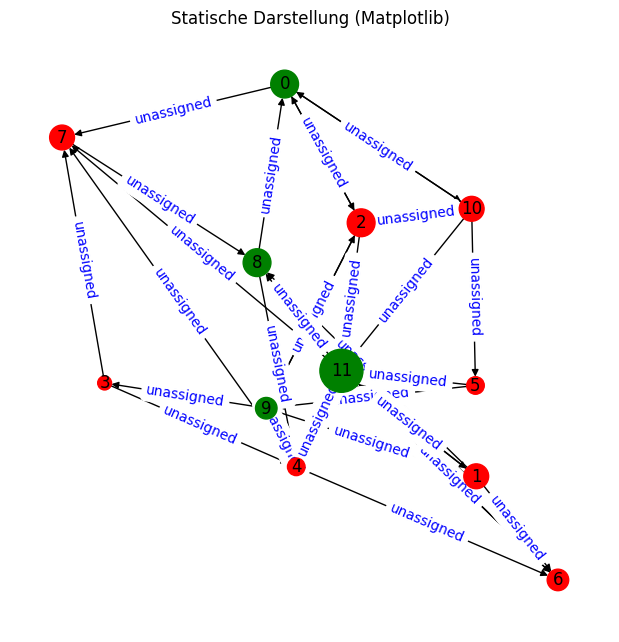

In [9]:
# Matplotlib-Fallback (statische Darstellung) mit Kanten-Labels für transported
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
node_colors = [ 'green' if G.nodes[n]['supply']>0 else ('red' if G.nodes[n]['supply']<0 else 'gray') for n in G.nodes() ]
node_sizes = [max(100, 300 if G.nodes[n]['supply']==0 else 80 * abs(G.nodes[n]['supply'])) for n in G.nodes()]
nx.draw(G, pos, with_labels=True, node_color=node_colors, arrows=True, node_size=node_sizes)
# Edge labels: 'unassigned' wenn transported < 0, sonst Wert
edge_labels = {(u, v): ('unassigned' if d.get('transported', -1) < 0 else str(d.get('transported'))) for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='blue')
plt.title('Statische Darstellung (Matplotlib)')
plt.show()

## Optional: Export mit pyvis (HTML)
Wenn du eine interaktive HTML-Datei zum Teilen erzeugen möchtest, kannst du `pyvis` verwenden. Nachstehend ein optionaler Code-Snippet (nicht automatisch ausgeführt):
````python
from pyvis.network import Network
nt = Network(notebook=True, height='600px', width='100%')
for nid, data in G.nodes(data=True):
    nt.add_node(nid, title=f'supply: {data.get('supply')}', color=('green' if data.get('supply')>0 else ('red' if data.get('supply')<0 else 'gray')))
for u, v in G.edges():
    nt.add_edge(u, v)
nt.show('graph.html')
````
Hinweis: `pyvis` erzeugt eine HTML-Datei (`graph.html`), die du im Browser öffnen kannst.

---
### Nächste Schritte / Hinweise
- Wenn du möchtest, kann ich das Notebook erweitern: z.B. interaktive Widgets (ipywidgets) zum Verändern von `seed`/`num_nodes`/`num_edges`, oder farbliche Skalen für magnitude der `supply`.
- Soll ich ein kurzes automatisiertes Test-Notebook hinzufügen, das beim Import prüft, dass `generate_random_directed_graph` läuft?